# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed
from base.model.decoder_debug import Decoder
from base.data.dataset import GeneExpressionDataset
from base.engine.train import train_dgd_mrna

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_is.tsv", sep='\t', index_col=[0])
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
def data_filtering(df, filter_zero=True, filter_tumor=True, filter_group_size=True):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
    
    return df

tcga_mrna = data_filtering(tcga_mrna_raw)

## Data Loader

In [7]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)

In [8]:
# make data split for train, validation, and test sets
train_ratio= 0.7
batch_size = 128

train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type']) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'])

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDataset(train_mrna, scaling_type='mean')
validation_dataset = GeneExpressionDataset(val_mrna, scaling_type='mean')
test_dataset = GeneExpressionDataset(test_mrna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

In [9]:
# make data split for train and validation sets
mrna_out_dim = tcga_mrna.shape[1]-4

In [10]:
print(train_mrna.shape)
print(val_mrna.shape)
print(test_mrna.shape)
print(mrna_out_dim)

(7053, 19745)
(1512, 19745)
(1512, 19745)
19741


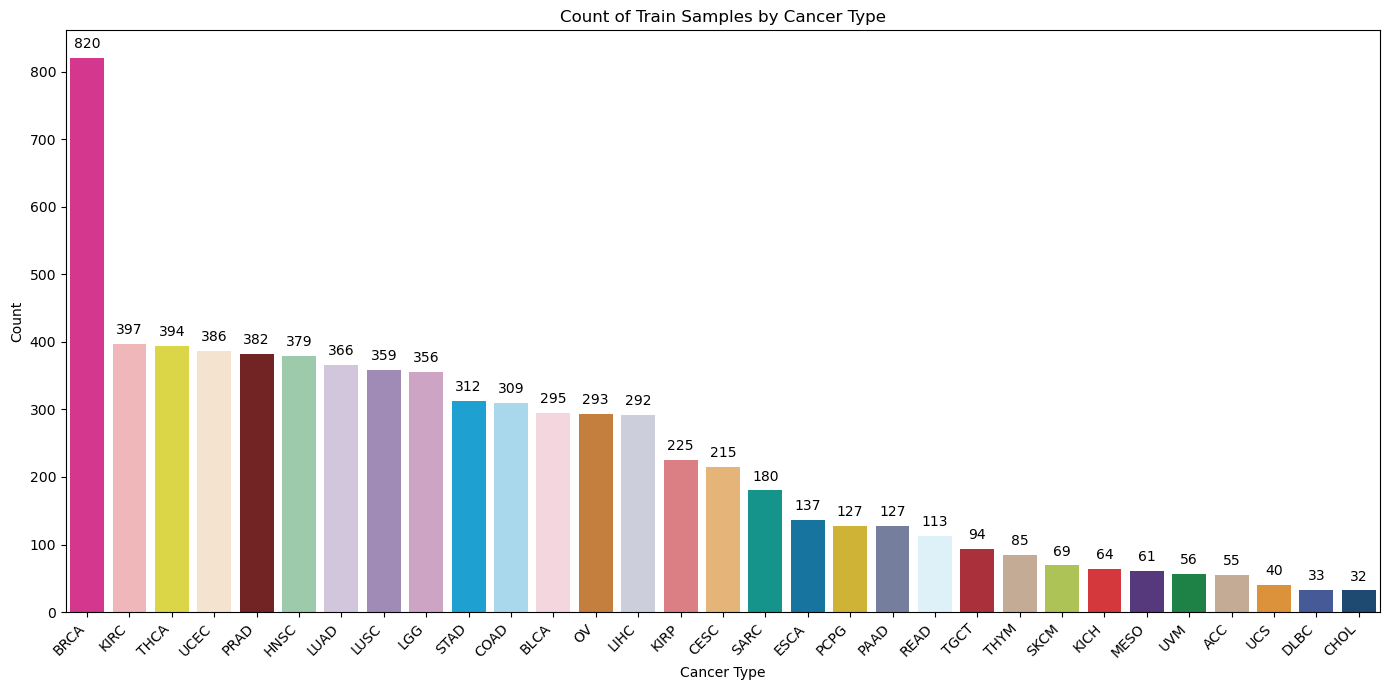

In [11]:
color_mapping = dict(zip(train_mrna['cancer_type'], train_mrna['color']))

primary_site_counts = train_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Train Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

# Model Setup

In [12]:
# This one is used for n GMM mixture component 
n_tissues = len(np.unique(train_dataset.label))
# n_tissues = 32

# Hyperparameters for Decoder
latent_dim = 20 # For the representation layer 
hidden_dims = [128, 128, 128] # Decoder common hidden dimension
reduction_type = "sum" # Output loss reduction, you can choose "mean". This is how you want calculate the total loss. 
activation = "relu" # ["relu", "leaky_relu"]
r_init = 2

# Hyperparameters for GMM
gmm_mean = 5.0 # usually between 2 and 10
sd_mean = 0.2 # default 0.2

In [13]:
# Output Module Setup
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mrna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, r_init=r_init, scaling_type="mean")
output_mrna_layer.n_features = mrna_out_dim

# Set up the decoder
decoder = Decoder(latent_dim, hidden_dims, output_module=output_mrna_layer).to(device)

# Setup GMM init
gmm_mean_scale = gmm_mean # usually between 2 and 10
sd_mean_init = sd_mean * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [14]:
# Init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

In [15]:
dgd # sanity check

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (out_module): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
)

## Training loop

In [16]:
# Training hyperparameters
learning_rates = {'dec':1e-4,'rep':0.01,'gmm':0.01}
weight_decay = 1e-6
betas = (0.5, 0.7)

nepochs = 501
pr = 5 # how often to print epoch
plot = 50 # how often to print plot

sample_index = [1382, 1310, 34, 360,
                765, 999, 2000, 93,
                0, 10, 20, 300, 
                123, 345, 456, 567,
                789, 12, 1050, 56,
                1, 2, 3, 4]

In [17]:
print("Hyperparameters:")
print(f"Latent dimension: {latent_dim}")
print(f"Learning rates: {learning_rates}")
print(f"Weight decay: {weight_decay}")
print(f"betas: {betas}")
print(f"Number of epochs: {nepochs}")
print(f"Hidden dimensions: {hidden_dims}")
print(f"Batch size: {batch_size}")
print(f"Reduction type: {reduction_type}")

Hyperparameters:
Latent dimension: 20
Learning rates: {'dec': 0.001, 'rep': 0.01, 'gmm': 0.01}
Weight decay: 1e-06
betas: (0.5, 0.7)
Number of epochs: 501
Hidden dimensions: [128, 128, 128]
Batch size: 128
Reduction type: sum


# Training

In [18]:
loss_tab = train_dgd_mrna(
        dgd, train_loader, validation_loader, device,
        learning_rates=learning_rates, weight_decay=weight_decay, betas=betas, 
        nepochs=nepochs, pr=pr, plot=plot, reduction_type=reduction_type,
        sample_index=sample_index, wandb_log=False
    )

  0%|                                                                                                                                                                                                                                                                                        | 0/501 [00:00<?, ?it/s]/home/farzamani/mambaforge/envs/midgd-env/lib/python3.10/site-packages/torchmetrics/functional/regression/mse.py:35: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  preds = preds.view(-1)
  0%|                                                                                                                                                                                                                                                                                        | 0/501 [01:16<?, ?it/s]


TypeError: Cannot interpret '-1' as a data type

# Plotting

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Display the plots
plt.show()

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for GMM loss
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Third subplot for RMSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson")
plt.xlabel("Epoch")
plt.ylabel("Pearson")

# Fourth subplot for RMSE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman")
plt.xlabel("Epoch")
plt.ylabel("Spearman")

# Display the plots
plt.show()

# Save Model

In [ ]:
save = True

if save:
    # Set results paths
    loss_path = 'results/0511_loss_mrna.pickle'
    dgd_path = 'results/0511_dgd_mrna.pickle'
    
    torch.save(loss_tab, loss_path)
    torch.save(dgd, dgd_path)

# Simple Analysis

In [ ]:
from base.dgd.latent import RepresentationLayer
from tqdm import tqdm

test_epochs = 301
gmm_loss = True

Ntest=len(test_loader.dataset)
if dgd.test_rep is None:
    dgd.test_rep = RepresentationLayer(dgd.rep_dim,Ntest).to(device)
test_rep_optimizer = torch.optim.AdamW(dgd.test_rep.parameters(), lr=learning_rates['rep'], weight_decay=weight_decay, betas=betas)

for epoch in tqdm(range(test_epochs)):
    test_rep_optimizer.zero_grad()
    dgd.eval()
    for (mirna_data, lib_mirna, index) in test_loader:
        recon_loss, gmm_loss = dgd.forward_and_loss(
            z=dgd.test_rep(index),
            target=mirna_data.to(device),  # Pass both mRNA and miRNA data
            scale=lib_mirna.unsqueeze(1).to(device),  # Pass both scales
            gmm_loss=gmm_loss,
            reduction=reduction_type,
            type="mirna"
        )
        loss = recon_loss + gmm_loss
        loss.backward()
    test_rep_optimizer.step()

In [ ]:
test_loader.dataset

In [ ]:
recon = []
data = []
dgd.eval() # Validation mode
for i, (mrna_data, lib_mrna, index) in enumerate(test_loader):
    recon.extend(dgd.forward(dgd.test_rep(index)) * lib_mrna.unsqueeze(1).to(device))
    data.extend(mrna_data)

In [ ]:
recon.detach().cpu()

In [ ]:
pd.DataFrame(recon.detach().cpu())

In [ ]:
X = recon.detach().cpu()
y = data.detach().cpu()

cancer_type = test_loader.dataset.label
color = test_loader.dataset.color
palette = dict(zip(cancer_type, color))

In [ ]:
from scipy import stats

mrna_features = train_loader.dataset.data.shape[1]
spearman_corr = []
pearson_corr = []
spearman_pval = []
pearson_pval = []

for i in range(y.shape[1]):
    # Calculate Spearman correlation coefficient
    spearman, spearman_p = stats.spearmanr(X[:,i], y[:,i])
    pearson, pearson_p = stats.pearsonr(X[:,i], y[:,i])
    spearman_corr.append(spearman)
    pearson_corr.append(pearson)
    spearman_pval.append(spearman_p)
    pearson_pval.append(spearman_p)
    
corr_data = pd.DataFrame(
    data={
        'spearman': spearman_corr, 
        'pearson': pearson_corr,
        'spearman_p': spearman_pval,
        'pearson_p': pearson_pval,
        'mirna': np.arange(0,mrna_features)
    },
    index=np.arange(0,mrna_features)
)
corr_data

In [ ]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=100)
plt.title("Spearman's Correlation")
plt.xlabel("Corr")

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=100)
plt.title("Pearson's Correlation")
plt.xlabel("Corr")

# Add the main title to the figure
fig.suptitle("mRNA Correlation Distribution", fontsize=24)

# Display the plots
plt.tight_layout()
plt.show()